In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
sys.path.append("..")

from utils import *
from errors import *

from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches


In [3]:
# Loaded a set of images
root_dir = "../../data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images from images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images from groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

n_train = 11 # Only use 10 images for training
n_test = n - n_train
imgs_tr = [imgs[i] for i in range(n_train)]
imgs_te = [imgs[i] for i in range(n_train, n)]

print(np.shape(imgs_tr))
print(np.shape(imgs_te))

Loading 20 images from images
Loading 20 images from groundtruth
(11, 400, 400, 3)
(9, 400, 400, 3)


### --- TESTING ON GRAY IMAGES ---

(11, 400, 400)
(9, 400, 400)


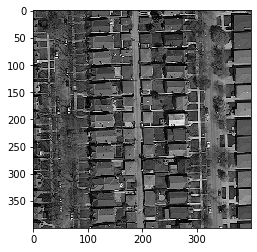

In [4]:
imgs_gray_tr = [rgb2gray(imgs_tr[i]) for i in range(n_train)]
imgs_gray_te = [rgb2gray(imgs_te[i]) for i in range(n_test)]

print(np.shape(imgs_gray_tr))
print(np.shape(imgs_gray_te))
plt.imshow(imgs_gray_tr[0], cmap='Greys_r')

### Linearize image

In [5]:
nb_image_tr, nb_x_tr, nb_y_tr = np.shape(imgs_gray_tr)
nb_image_te, nb_x_te, nb_y_te = np.shape(imgs_gray_te)
imgs_gray_lin_tr = np.zeros((nb_image_tr, nb_x_tr*nb_y_tr))
imgs_gray_lin_te = np.zeros((nb_image_te, nb_x_te*nb_y_te))

for k in range(nb_image_tr):
    imgs_gray_lin_tr[k] = np.asarray([imgs_gray_tr[k][i][j] for i in range(nb_x_tr) for j in range(nb_y_tr)])
for k in range(nb_image_te):
    imgs_gray_lin_te[k] = np.asarray([imgs_gray_te[k][i][j] for i in range(nb_x_te) for j in range(nb_y_te)])

print("Train : " + str(np.shape(imgs_gray_lin_tr)))
print("Test : " + str(np.shape(imgs_gray_lin_te)))




Train : (11, 160000)
Test : (9, 160000)


### NORMALIZATION 
##### (Don't know if we need to normalize)

In [6]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(imgs_gray_lin_tr)
# Apply transform to both the training set and the test set.
imgs_gray_lin_tr = scaler.transform(imgs_gray_lin_tr)
imgs_gray_lin_te = scaler.transform(imgs_gray_lin_te)

### PCA decomposition on train

In [7]:
DISPLAY_IMAGES = False
KEEP_COMPONENTS = 0.98

In [8]:
pca = PCA(KEEP_COMPONENTS)
pca.fit(imgs_gray_lin_tr)
imgs_gray_pca = pca.fit_transform(imgs_gray_lin_tr)
print('Before PCA decomposition: ' + str(np.shape(imgs_gray_lin_tr)))
print('After PCA decomposition: ' + str(np.shape(imgs_gray_pca)))
imgs_gray_restored = pca.inverse_transform(imgs_gray_pca)
imgs_gray_restored = imgs_gray_restored.reshape((nb_image_tr, nb_x_tr, nb_y_tr))
if DISPLAY_IMAGES:
    for i in range(np.shape(imgs_gray_tr)[0]):
        cimg = np.concatenate((imgs_gray_lin_tr.reshape((nb_image_tr, nb_x_tr, nb_y_tr))[i], imgs_gray_restored[i]), axis=1)
        plt.imshow(cimg, cmap='Greys_r')
        plt.xlabel('Image ' + str(i) + ': Original vs Reconstruct with ' + str(np.shape(imgs_gray_pca)[1]) + ' components')
        plt.show()

Before PCA decomposition: (11, 160000)
After PCA decomposition: (11, 10)


### Display some statistics of PCA decompostion

In [9]:
print('Keeping ' + str(KEEP_COMPONENTS) + ' % of the principal components:')
reduction = (1 - float(np.size(imgs_gray_pca)) / np.size(imgs_gray_tr)) * 100
print('Reduction in the number of component of ' + str(reduction) + ' %')
average_mse = 0 
for i in range(np.shape(imgs_gray_tr)[0]):
    average_mse += mse(imgs_gray_lin_tr.reshape((nb_image_tr, nb_x_tr, nb_y_tr))[i], imgs_gray_restored[i])
print('Cummulative mean square error of the PCA: ' + str(average_mse))
average_mse /= np.shape(imgs_gray_tr)[0]
print('Average mean square error of the PCA: ' + str(average_mse))


Keeping 0.98 % of the principal components:
Reduction in the number of component of 99.99375 %
Cummulative mean square error of the PCA: 1.2246846060495646e-27
Average mean square error of the PCA: 1.1133496418632405e-28


### --- TESTING ON COLOR IMAGES ---

### Linearize image

In [41]:
nb_image_tr, nb_x_tr, nb_y_tr, nb_channels_tr = np.shape(imgs_tr)
nb_image_te, nb_x_te, nb_y_te, nb_channels_te = np.shape(imgs_te)

imgs_lin_tr = np.zeros((nb_image_tr, nb_x_tr*nb_y_tr*nb_channels_tr))
imgs_lin_te = np.zeros((nb_image_te, nb_x_te*nb_y_te*nb_channels_te))

for k in range(nb_image_tr):
    imgs_lin_tr[k] = np.asarray([imgs_tr[k][i][j][c] for i in range(nb_x_tr) for j in range(nb_y_tr) for c in range(nb_channels_tr)])
for k in range(nb_image_te):
    imgs_lin_te[k] = np.asarray([imgs_te[k][i][j][c] for i in range(nb_x_te) for j in range(nb_y_te) for c in range(nb_channels_te)])

print("Train : " + str(np.shape(imgs_lin_tr)))
print("Test : " + str(np.shape(imgs_lin_te)))

Train : (11, 480000)
Test : (9, 480000)


### Verification of the linearization process

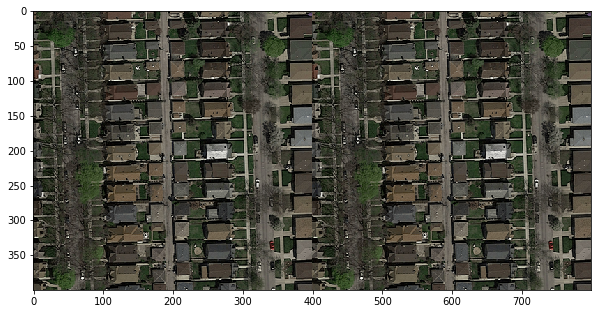

In [42]:
assert(np.shape(imgs_tr) == np.shape(imgs_lin_tr.reshape((nb_image_tr, nb_x_tr, nb_y_tr, nb_channels_tr))))

cimg = concatenate_images(imgs[0], imgs_lin_tr.reshape((nb_image_tr, nb_x_tr, nb_y_tr, nb_channels_tr))[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)

### NORMALIZATION 
##### (Don't know if we need to normalize)

In [43]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(imgs_lin_tr)
# Apply transform to both the training set and the test set.
imgs_lin_tr = scaler.transform(imgs_lin_tr)
imgs_lin_te = scaler.transform(imgs_lin_te)

imgs_normalized_tr = imgs_lin_tr.reshape((nb_image_tr, nb_x_tr, nb_y_tr, nb_channels_tr))
imgs_normalized_te = imgs_lin_te.reshape((nb_image_te, nb_x_te, nb_y_te, nb_channels_te))

### PCA decomposition

In [44]:
DISPLAY_IMAGES = True
KEEP_COMPONENTS = 0.98

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Before PCA decomposition: (11, 480000)
After PCA decomposition: (11, 10)


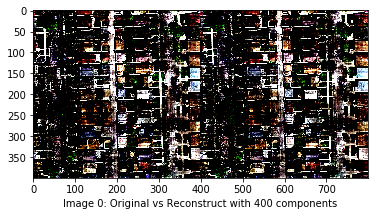

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


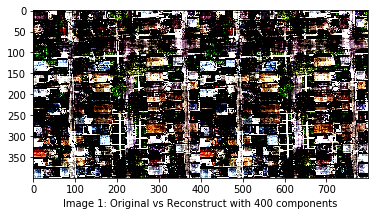

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


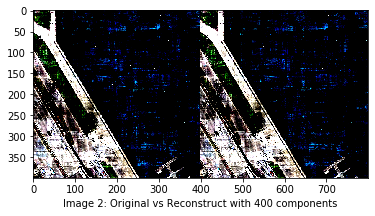

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


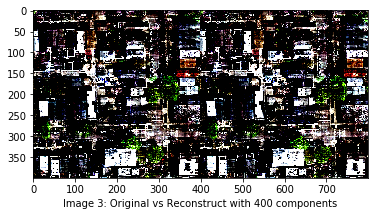

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


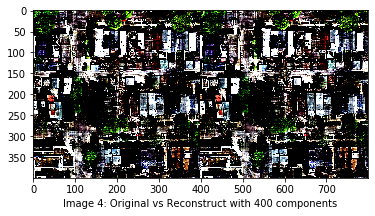

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


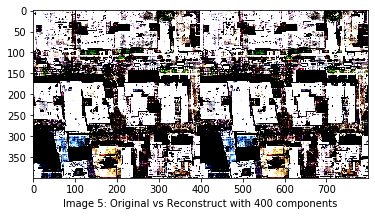

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


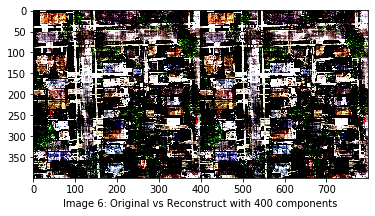

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


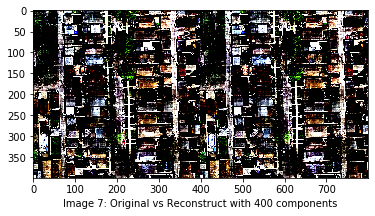

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


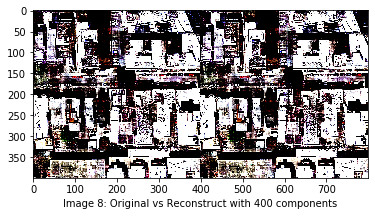

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


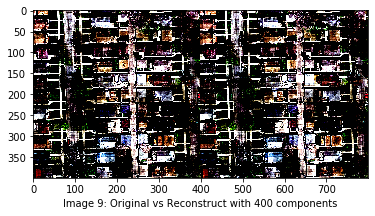

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


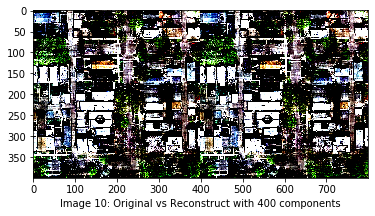

In [45]:
pca = PCA(KEEP_COMPONENTS)
pca.fit(imgs_lin_tr)
imgs_pca = pca.fit_transform(imgs_lin_tr)
print('Before PCA decomposition: ' + str(np.shape(imgs_lin_tr)))
print('After PCA decomposition: ' + str(np.shape(imgs_pca)))
imgs_restored = pca.inverse_transform(imgs_pca)
imgs_restored = imgs_restored.reshape((nb_image_tr, nb_x_tr, nb_y_tr, nb_channels_tr))
#Normalization of the restored image
#imgs_restored = np.where(imgs_restored<0, 0, imgs_restored)
#imgs_restored = np.where(imgs_restored>1, 1, imgs_restored)
if DISPLAY_IMAGES:
    for i in range(np.shape(imgs_tr)[0]):
        cimg = np.concatenate((imgs_normalized_tr[i], imgs_restored[i]), axis=1)
        plt.imshow(cimg)
        plt.xlabel('Image ' + str(i) + ': Original vs Reconstruct with ' + str(np.shape(imgs_tr)[1]) + ' components')
        plt.show()

### Display some statistics of PCA decompostion

In [46]:
reduction = (1 - float(np.size(imgs_pca)) / np.size(imgs_tr)) * 100
print('Reduction in the number of component of ' + str(reduction) + ' %')
average_mse = 0 
for i in range(nb_image_tr):
    average_mse += mse(imgs_normalized_tr[i], imgs_restored[i])
print('Cummulative mean square error of the PCA: ' + str(average_mse))
average_mse /= nb_image_tr
print('Average mean square error of the PCA: ' + str(average_mse))


Reduction in the number of component of 99.99791666666667 %
Cummulative mean square error of the PCA: 1.033383626451632e-27
Average mean square error of the PCA: 9.394396604105746e-29


### Verification of reconstruction of other images

In [47]:
DISPLAY_IMAGES = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


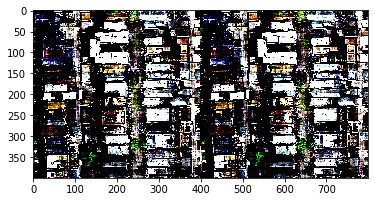

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


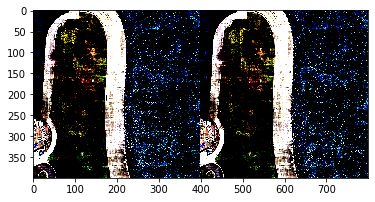

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


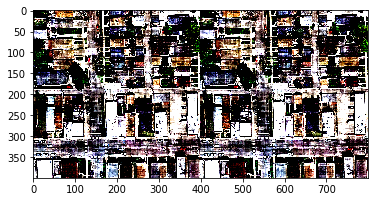

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


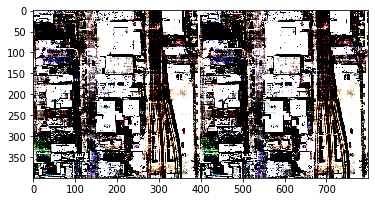

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


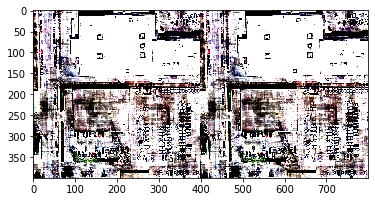

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


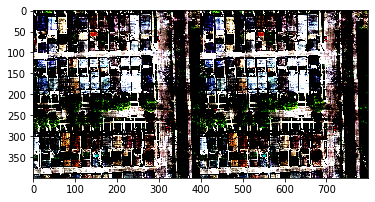

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


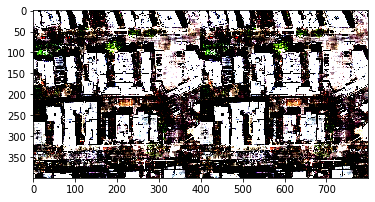

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


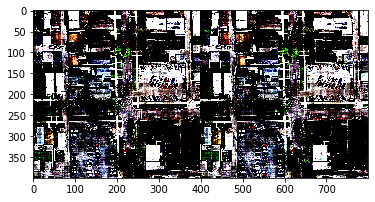

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


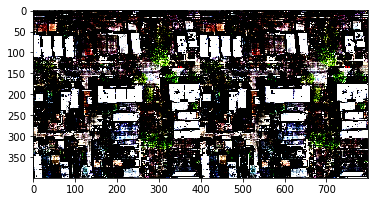

In [50]:
imgs_pca_te = pca.fit_transform(imgs_lin_te)
imgs_restored_te = pca.inverse_transform(imgs_pca_te)
imgs_restored_te = imgs_restored_te.reshape((nb_image_te, nb_x_te, nb_y_te, nb_channels_te))


if DISPLAY_IMAGES:
    for i in range(np.shape(imgs_te)[0]):
        cimg = np.concatenate((imgs_normalized_te[i], imgs_restored_te[i]), axis=1)
        plt.imshow(cimg)
        plt.show()

### Display some statistics of PCA decompostion

In [51]:
reduction = (1 - float(np.size(imgs_pca_te)) / np.size(imgs_te)) * 100
print('Reduction in the number of component of ' + str(reduction) + ' %')
average_mse = 0 
for i in range(nb_image_te):
    average_mse += mse(imgs_normalized_te[i], imgs_restored_te[i])
print('Cummulative mean square error of the PCA: ' + str(average_mse))
average_mse /= nb_image_te
print('Average mean square error of the PCA: ' + str(average_mse))

Reduction in the number of component of 99.99833333333333 %
Cummulative mean square error of the PCA: 4.391050129155323e-27
Average mean square error of the PCA: 4.878944587950359e-28
